In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imagehash
import tqdm

from PIL import Image
from pathlib import Path
from collections import defaultdict

pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(12, 6)
plt.rcParams['font.size']=10

In [2]:
# Dataset loading
DATASET_PATH='../../data/food-101/food-101'

dataset_path=Path(DATASET_PATH)
images_path=dataset_path/'images'
meta_path=dataset_path/'meta'

In [3]:
# Count images per class
class_folders=sorted([d for d in images_path.iterdir() if d.is_dir()])

class_counts={}
for class_folder in tqdm.tqdm(class_folders, desc='Processing classes'):
    images=list(class_folder.glob('*.jpg')) + \
        list(class_folder.glob('*.png')) + \
        list(class_folder.glob('*.jpeg'))
    class_counts[class_folder.name]=len(images)

class_counts_df=pd.DataFrame(
    list(class_counts.items()), columns=['Class', 'Image_Count']
).sort_values('Image_Count', ascending=False).reset_index(drop=True)

counts=class_counts_df['Image_Count']
total_images=counts.sum()
num_classes=len(class_counts_df)
mean_count=counts.mean()
median_count=counts.median()
std_count=counts.std()
min_count=counts.min()
max_count=counts.max()

Processing classes: 100%|██████████| 101/101 [00:01<00:00, 79.91it/s]


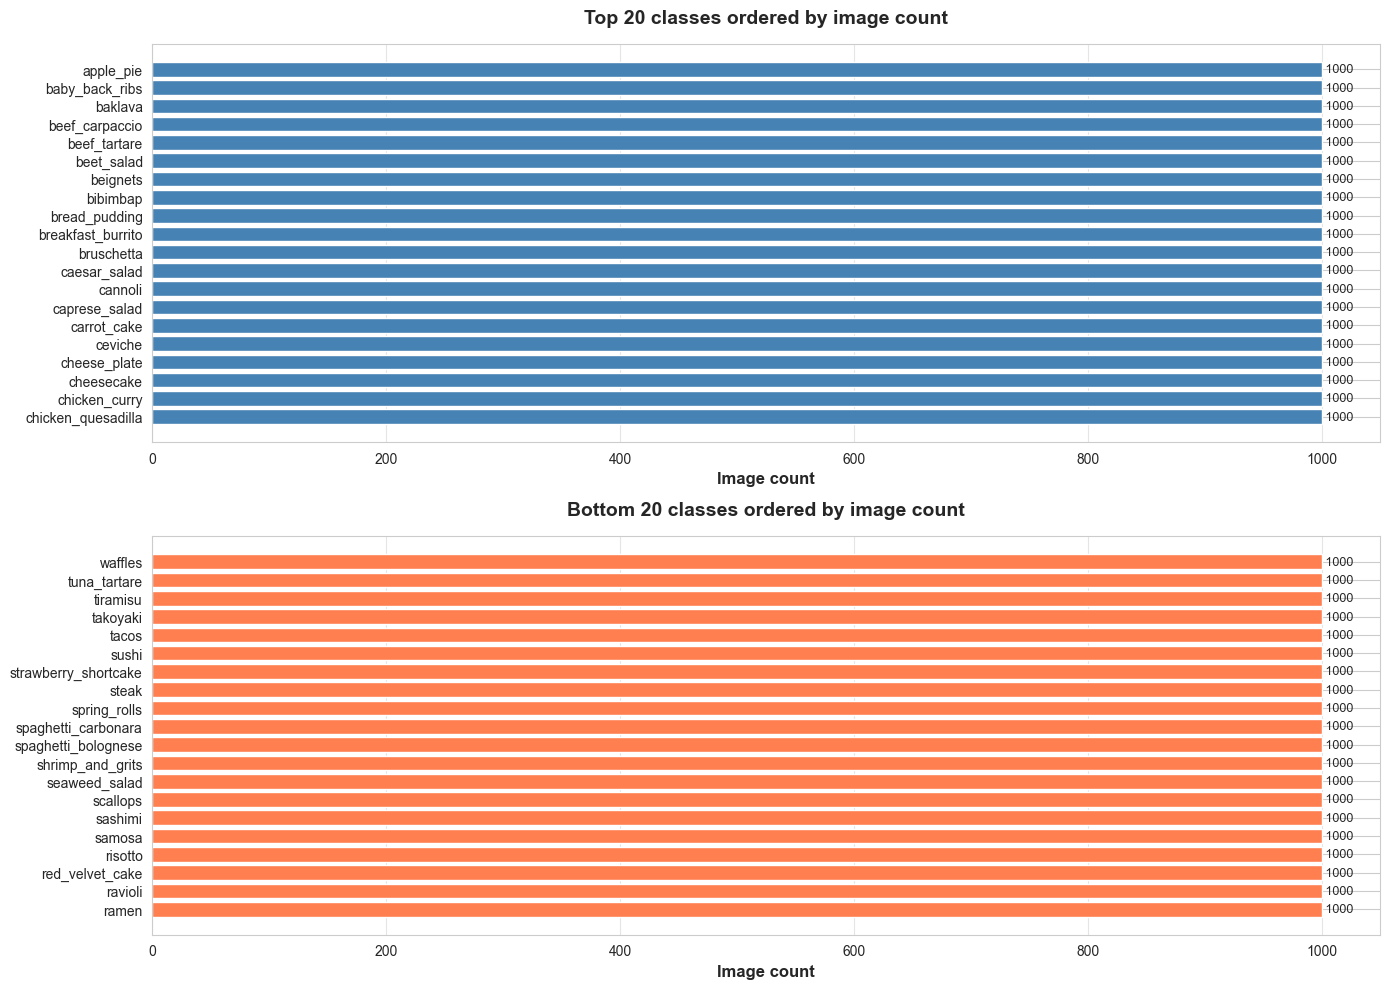

In [4]:
# Bar chart viz
fig, (ax1, ax2)=plt.subplots(2, 1, figsize=(14, 10))

top_20=class_counts_df.head(20)
bar1=ax1.barh(range(len(top_20)), top_20['Image_Count'], color='steelblue')
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['Class'])
ax1.set_xlabel('Image count', fontsize=12, fontweight='bold')
ax1.set_title('Top 20 classes ordered by image count', fontsize=14, fontweight='bold', pad=15)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.5)

for i, bar in enumerate(bar1):
    width=bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f' {int(width)}', ha='left', va='center', fontsize=9)

bot_20=class_counts_df.tail(20)
bar2=ax2.barh(range(len(bot_20)), bot_20['Image_Count'], color='coral')
ax2.set_yticks(range(len(bot_20)))
ax2.set_yticklabels(bot_20['Class'])
ax2.set_xlabel('Image count', fontsize=(12), fontweight='bold')
ax2.set_title('Bottom 20 classes ordered by image count', fontsize=14, fontweight='bold', pad=15)
ax2.invert_yaxis
ax2.grid(axis='x', alpha=0.5)

for i, bar in enumerate(bar2):
    width=bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f' {int(width)}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/class_distribution_top_and_bottom.png', dpi=300, bbox_inches='tight')
plt.show()

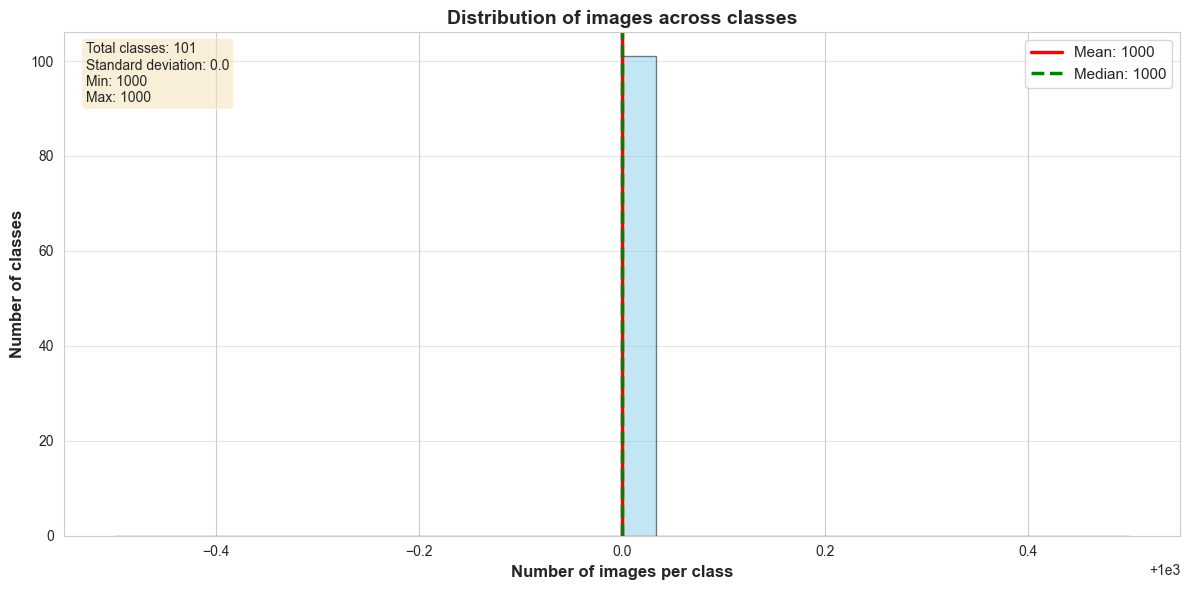

In [5]:
# Histogram vis
fig, ax=plt.subplots(figsize=(12,6))

n, bins, patches=plt.hist(class_counts_df['Image_Count'], bins=30, color='skyblue', edgecolor='black', alpha=0.5)

mean_line=ax.axvline(mean_count, color='red', linestyle='-', linewidth=2.5, label=f'Mean: {mean_count:.0f}')
median_line=ax.axvline(median_count, color='green', linestyle='--', linewidth=2.5, label=f'Median: {median_count:.0f}')

ax.set_title('Distribution of images across classes', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of images per class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of classes', fontsize=12, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.5)

textstr=f'Total classes: {num_classes}\nStandard deviation: {std_count}\nMin: {min_count}\nMax: {max_count}' 
props=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('figures/distribution_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
#ID dupes
hash_size=8
hash_dict=defaultdict(list)

all_images=[]
for class_folder in images_path.iterdir():
    if class_folder.is_dir():
        all_images.extend(list(class_folder.glob('*.jpg')))
        all_images.extend(list(class_folder.glob('*.png')))
        all_images.extend(list(class_folder.glob('*.jpeg')))

for img_path in tqdm.tqdm(all_images, desc='Computing hashes'):
    try:
        with Image.open(img_path) as img:
            # img=img.convert("RGB")
            img_hash=imagehash.phash(img, hash_size=hash_size)
            hash_dict[str(img_hash)].append(img_path)
    except Exception as e:
        print(f'Error processing {img_path.name}: {e}')

duplicates={h: paths for h, paths in hash_dict.items() if len(paths)>1}
total_duplicate_images=sum(len(paths)-1 for paths in duplicates.values())

if duplicates:
    print(f'Duplicate groups')
    for i, (h, paths) in enumerate(list(duplicates.items())[:5], 1):
        print(f'{i}. Hash: {h} ({len(paths)} copies)')
        for j, path in enumerate(paths[: 3], 1):
            print(f'  {j}. {Path(path).parent.name}/{Path(path).name}')
        if len(paths) > 3: 
            print(f'and {len(paths)-3} more')
else:
    print(f'No duplcate images found')

Computing hashes: 100%|██████████| 101000/101000 [17:59<00:00, 93.53it/s] 

Duplicate groups
1. Hash: fdc1632390438777 (2 copies)
  1. apple_pie/1461580.jpg
  2. apple_pie/1469191.jpg
2. Hash: 8ad45abc3c98e03f (2 copies)
  1. apple_pie/839808.jpg
  2. apple_pie/839845.jpg
3. Hash: e2f6c52b1fe19e00 (2 copies)
  1. baby_back_ribs/3124916.jpg
  2. baby_back_ribs/3125728.jpg
4. Hash: 9990c446873fb53d (2 copies)
  1. baby_back_ribs/3217591.jpg
  2. baby_back_ribs/3265047.jpg
5. Hash: ced5f14ef0284569 (2 copies)
  1. baby_back_ribs/620996.jpg
  2. baby_back_ribs/620997.jpg


In [ ]:
# Flag corrupt imgs
corrupted=[]
flagged=[]

for img_path in tqdm.tqdm(all_images, desc='Verifying images'):
    try:
        with Image.open(img_path) as img: 
            img.verify()
        with Image.open(img_path) as img:
            img.load()

            width, height=img.size

            if width < 10 or height < 10:
                flagged.append({
                    'path': str(img_path),
                    'class': img_path.parent.name,
                    'issue': f'Very small: {width}x{height}px'
                })            
            aspect_ratio=width/height
            if aspect_ratio > 10 or aspect_ratio < 0.1:
                flagged.append({
                    'path': str(img_path),
                    'class': img_path.parent.name,
                    'issue': f'Unusual aspect ratio: {aspect_ratio}'
                })            
            if img.mode not in ['RGB', 'L', 'RGBA']:
                flagged.append({
                    'path': str(img_path), 
                    'class': img_path.parent.name, 
                    'issue': f'Unusual image color: {img.mode}'
                })

    except Exception as e:
        corrupted.append({
            'path': str(img_path),
            'class': img_path.parent.name,
            'error': str(e)
        })

if corrupted: 
    print(f'Corrupted images found')
    for i, item in enumerate(corrupted[:10], 1):
        print(f'{i}, {item['class']}/{Path(item['path']).name}')
        print(f'Error: {item['error']}')
    if len(corrupted) > 10: 
        print(f'and {len(corrupted)-10} more' )
else:
    print(f'No corrupted imgaes found')
    
if flagged:
    print(f'Risky images found')
    for i, item in enumerate(flagged[:10], 1):
        print(f'{i}, {item['class']}/{Path(item['path']).name}')
        print(f'Issue: {item['issue']}')
    if len(flagged) > 10:
        print(f'and {len(flagged)-10} more')
else:
    print(f'No risky images found')

Verifying images: 100%|██████████| 101000/101000 [01:48<00:00, 934.05it/s]

No corrupted imgaes found
No risky images found
